In [2]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma
from scipy.integrate import trapz, simpson
import pandas as pd
import os
from importlib import reload

plt.style.use("../KD_style.mplstyle")

In [3]:
def acceptreject_faster(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran < yfunc]
    ykeep = yran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest = acceptreject_faster(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    return finalx, finaly

def acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran < yfunc]
    ykeep = yran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest, all_xrest, all_yrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.array([])
        yrest = np.array([])
        all_xrest = np.array([])
        all_yrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    allx = np.append(xran, all_xrest)
    ally = np.append(yran, all_yrest)
    finaltries = N_points + tries
    return finalx, finaly, allx, ally, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    x, y, all_x, all_y, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, y, area, all_x, all_y, eff, tries

def num_int2(func, xmin, xmax, points = 1000000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    y = func(x, **kwargs)
    y_ave = y[1:] + (y[1:] - y[:-1])/2
    width = (xmax-xmin)/(points-1)
    area = np.sum(y_ave)*width
    return area

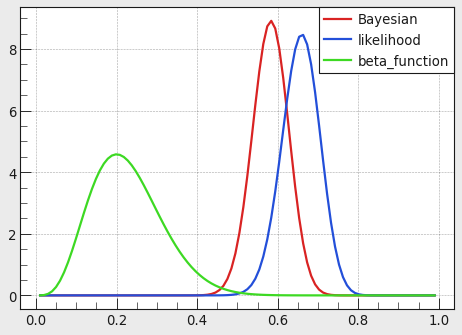

In [4]:
def beta_func(x, alpha, beta):
    return gamma(alpha + beta)/(gamma(alpha)*gamma(beta)) * x**(alpha-1) * (1 - x)**(beta - 1)

def lh(success, trails,p):
    return binom.pmf(success, trails, p)

def bayesian(likelihood, prior, marginal_like):
    posterior = likelihood * prior/marginal_like
    return posterior

n = 100
heads = 66

p = np.linspace(0.01, 0.99, 100)

alpha = 5
beta = 17

prior = beta_func(p, alpha, beta)
likelihood = lh(heads, n, p)
likelihood /= simpson(likelihood, p)

posterior = bayesian(likelihood, prior, 1)
posterior /= simpson(posterior, p)

plt.plot(p, posterior, label = "Bayesian")
plt.plot(p, likelihood, label = "likelihood")
plt.plot(p, prior, label ="beta_function")
plt.legend()

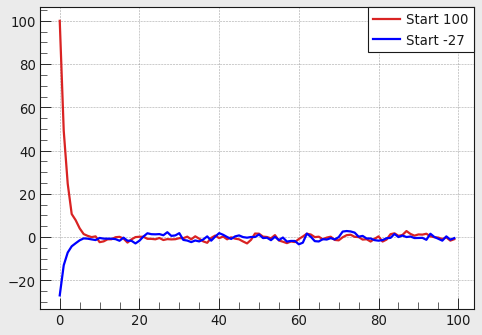

In [5]:
def gauss_MC(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi))* np.exp(-1/2*(x-0.5 * mu)**2/sigma**2)

steps = np.arange(0, 100, 1)
# steps = np.arange(0, iterations, 1)
sigma = 1
mu = 100

mu_values = np.zeros(len(steps))
mu_values[0] = mu
for step in steps[1:]:
    xmin = 0.5*mu - 6 * sigma
    xmax = 0.5*mu + 6 * sigma
    ymin = 0
    ymax = stats.norm.pdf(mu, mu, sigma)
    x,_, _,_,_ = acceptreject(gauss_MC, xmin, xmax, ymin, ymax, N_points = 1, mu = mu, sigma = sigma)
    mu = x
    mu_values[step] = mu
    
plt.plot(steps, mu_values, label = "Start 100")

sigma = 1
mu = -27

mu_values = np.zeros(len(steps))
mu_values[0] = mu
for step in steps[1:]:
    xmin = 0.5*mu - 4 * sigma
    xmax = 0.5*mu + 4 * sigma
    ymin = 0
    ymax = stats.norm.pdf(mu, mu, sigma)
    x,_, _,_,_ = acceptreject(gauss_MC, xmin, xmax, ymin, ymax, N_points = 1, mu = mu, sigma = sigma)
    mu = x
    mu_values[step] = mu
    
plt.plot(steps, mu_values, color = "b", label = "Start -27")
plt.legend()

## Exercise 3

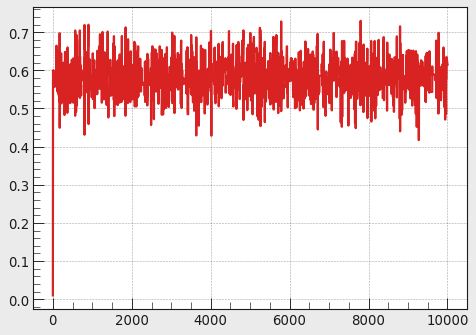

In [6]:
def beta_func(x, alpha, beta):
    return gamma(alpha + beta)/(gamma(alpha)*gamma(beta)) * x**(alpha-1) * (1 - x)**(beta - 1)

def lh(success, trails, p):
    return binom.pmf(success, trails, p)

def bayesian(likelihood, prior, marginal_like):
    posterior = likelihood * prior/marginal_like
    return posterior

def gauss(x, mu, sigma):
    return stats.norm.pdf(x, mu, sigma)

n = 100
heads = 66

theta = 0.01

alpha = 5
beta = 17

pdf_mu = 0
pdf_sigma = 0.3

xmin = pdf_mu - 4*pdf_sigma
xmax = pdf_mu + 4*pdf_sigma
ymin = 0
ymax = stats.norm.pdf(mu,mu,sigma)
N_steps = 10000
steps = np.arange(0,N_steps)
theta_array = np.zeros(N_steps)
theta_array[0] = theta
for step in steps[1:]:
    pdf_add,_ = acceptreject_faster(gauss, xmin, xmax, ymin, ymax, 1, mu=pdf_mu, sigma = pdf_sigma)
    theta_new = theta + pdf_add
    while theta_new <= 0 or theta_new >= 1:
        pdf_add,_ = acceptreject_faster(gauss, xmin, xmax, ymin, ymax, 1, mu=pdf_mu, sigma = pdf_sigma)
        theta_new = theta + pdf_add

    prior_old = beta_func(theta, alpha, beta)
    likelihood_old = lh(heads, n, theta)
    posterior_old = bayesian(likelihood_old, prior_old, 1)

    prior_new = beta_func(theta_new, alpha, beta)
    likelihood_new = lh(heads, n, theta_new)
    posterior_new = bayesian(likelihood_new, prior_new, 1)

    r = posterior_new/posterior_old
    if r >= 1:
        theta = theta_new
    else:
        if r > np.random.uniform(0,1):
            theta = theta_new
        else:
            pass
    theta_array[step] = theta

plt.plot(steps, theta_array)

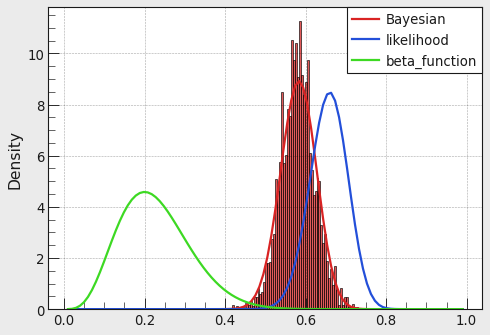

In [7]:
sns.histplot(theta_array[5:], stat = "density")
plt.plot(p, posterior, label = "Bayesian")
plt.plot(p, likelihood, label = "likelihood")
plt.plot(p, prior, label ="beta_function")
plt.legend()